In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 # Carregar imagens
from skimage import io # Funções de pré-processamento de imagem
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Dense, Input, AveragePooling2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, UpSampling2D, Concatenate
from tensorflow.keras.applications import ResNet50 # Criar o modelo de classificação
from tensorflow.keras.models import Model, load_model # Carregar o modelo e definir a rede neural
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # Salvar os pesos da rede neural
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path_archives = '/content/drive/MyDrive/Ciência de Dados para Empresas e Negócios/Ciência de Dados para Empresas e Negócios/Departamento de manutenção/'

# Segmentação de imagens com RESUNET

In [4]:
defect_class_mask_df = pd.read_csv(path_archives+'train.csv')
defect_class_mask_df

,ImageId,ClassId,EncodedPixels
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...
...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(defect_class_mask_df, test_size = .2)
X_train.shape, X_val.shape

((4598, 3), (1150, 3))

Criar estrutura de dados de lista para conseguir treinar o modelo

In [6]:
train_ids   = list(X_train['ImageId'])
train_class = list(X_train['ClassId'])
train_rle   = list(X_train['EncodedPixels'])
len(train_ids), len(train_class), len(train_rle)

(4598, 4598, 4598)

In [7]:
val_ids   = list(X_val['ImageId'])
val_class = list(X_val['ClassId'])
val_rle   = list(X_val['EncodedPixels'])
len(val_ids), len(val_class), len(val_rle)

(1150, 1150, 1150)

In [8]:
cd /content/drive/MyDrive/Ciência de Dados para Empresas e Negócios/Ciência de Dados para Empresas e Negócios/Departamento de manutenção

/content/drive/.shortcut-targets-by-id/1LiZyvy49Ts4x2TyIp-UWJ2nxQ_0nfl5I/Ciência de Dados para Empresas e Negócios/Departamento de manutenção


In [9]:
train_dir = '/content/drive/MyDrive/Ciência de Dados para Empresas e Ngócios/Ciência de Dados para Empresas e Negócios/Departamento de manutenção/train_images/'
path = '/content/drive/MyDrive/Ciência de Dados para Empresas e Negócios/'

In [10]:
from utilities import DataGenerator
training_generator   = DataGenerator(train_ids, train_class, train_rle, train_dir) 
validation_generator = DataGenerator(val_ids, val_class, val_rle, train_dir) 

Iniciando a construção da arquitetura.  

Estamos utilizando valores indicados na documentação dos artigos sobre esses tipo de rede neural.  

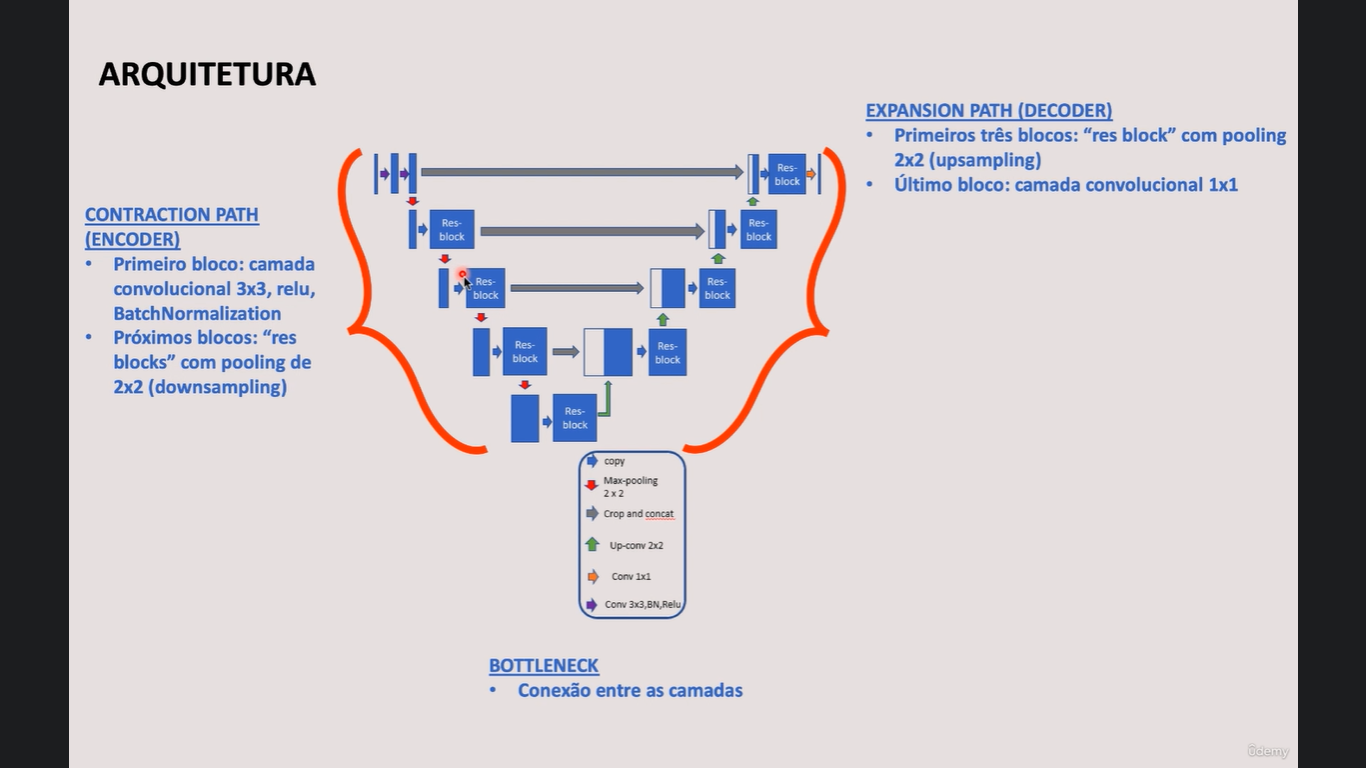

In [11]:
# X: input
# X_copy: Realizando a cópia da camada antes de fazer o processamento
def resblock(X, f):
  '''Função vai gerar somente 1 resblock'''
  X_copy = X
  
  # Strides: varrer a imagem de 1 a 1 pixel 
  # Kernel_initializer: tipo da inicialização dos pesos que será feita nessa camada
  X = Conv2D(f, kernel_size = (1,1), strides = (1,1), kernel_initializer='he_normal')(X)
  X = BatchNormalization()(X) # Normalização das camadas
  X = Activation('relu')(X)
  
  X = Conv2D(f, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer='he_normal')(X)
  X =  BatchNormalization()(X)

  X_copy = Conv2D(f, kernel_size = (1,1), strides = (1,1), kernel_initializer='he_normal')(X_copy)
  X_copy =  BatchNormalization()(X_copy)
  # Processo de adição da cópia
  X = Add()([X, X_copy])
  X = Activation('relu')(X)

  return X

In [12]:
def upsample_concat(X, skip):
  '''Aumenta a dimensionalidade e concatena com a camada do resblock'''
  X = UpSampling2D((2,2))(X)
  merge = Concatenate()([X, skip])
  return merge


In [13]:
input_shape = (256, 256, 1) #1 = Escala de cinza

X_input = Input(input_shape) #camada de entrada
# Estágio 1
  #16 filtros de características | valor do kernelsize de 3
  #padding same é para aproveitar toda a imagem
conv1_in = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1   = MaxPool2D((2,2))(conv1_in)

# Estágio 2
conv2_in = resblock(pool_1 ,32) # 32 filtros
pool_2   = MaxPool2D(pool_size = (2,2))(conv2_in)

# Estágio 3
conv3_in = resblock(pool_2 ,64) # 64 filtros
pool_3   = MaxPool2D((2,2))(conv3_in)

# Estágio 4
conv4_in = resblock(pool_3 ,128) # 128 filtros
pool_4   = MaxPool2D((2,2))(conv4_in)

# Estágio 5
conv5_in = resblock(pool_4, 256) # 256 filtros

# Up 1
up_1 = upsample_concat(conv5_in, conv4_in) # Conxão do skip connection
up_1 = resblock(up_1, 128)

# Up 2
up_2 = upsample_concat(up_1, conv3_in) # Conxão do skip connection
up_2 = resblock(up_2, 64)

# Up 3
up_3 = upsample_concat(up_2, conv2_in) # Conxão do skip connection
up_3 = resblock(up_3, 32)

# Up 3
up_4 = upsample_concat(up_3, conv1_in) # Conxão do skip connection
up_4 = resblock(up_4, 16)

# Final
output = Conv2D(4, (1,1), padding = 'same', activation = 'sigmoid')(up_4) # Sigmoid vai gerar uma saida para cada pixel da imagem
model_seg = Model(inputs = X_input, outputs = output)

## Loss Function
Com o problema de segmentação de imagem, fica mais difícil utilizar métricas tradicionaias em redes neurais para problemas mais clássicos.  

O **Focal Tversky** é uma função de métrica de erro baseada em um índice chamado Tversky. Ela é nova (2018) e bastante recomendada para segmentação de imagem.

In [14]:
from utilities import focal_tversky, tversky_loss, tversky

In [15]:
# Criando otimizador para ajustes dos pesos
# Learning rate
# epsilon É utilizado principalmente quando se tem muitas camadas
## epsilon é utilizado juntamente com o Learning Rate para fazer os ajustes dos pesos
adam = tf.keras.optimizers.Adam(lr=0.05, epsilon=0.1 )
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
# Parar o treinamento se o val_loss não tiver melhoras significativas por 20 epochs seguidas
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1,
                              patience = 20)

checkpointer = ModelCheckpoint(filepath = path+'resunet-segmentation-weights.hdf5',
                               verbose = 1, save_best_only = True)

Realizando o treinamento

In [17]:
# history = model_seg.fit(training_generator, epochs = 40,
#                                   validation_data = validation_generator,
#                                   callbacks = [checkpointer, earlystopping])

In [18]:
# # Salvando o modelo
# model_json = model_seg.to_json()
# with open('resunet-segmentation-model.json', 'w') as json_file:
#     json_file.write(model_json)

# Avaliação Resnet

In [24]:
# Carregando a estrutura do modelo
path_model = '/content/drive/MyDrive/Ciência de Dados para Empresas e Negócios/Ciência de Dados para Empresas e Negócios/Departamento de manutenção/'
with open(path_model+'resunet-segmentation-model.json') as json_file:
  json_save_model = json_file.read()
json_save_model

'{"class_name": "Functional", "config": {"name": "model_1", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 256, 256, 1], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_2"}, "name": "input_2", "inbound_nodes": []}, {"class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "dtype": "float32", "filters": 16, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "HeNormal", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "name": "conv2d", "inbound_nodes": [[["input_2", 0, 0, {}]]]}, {"class_name": "BatchNormalization", "config": {"name": "batch_normalization", "trainable": true, "dtype": "float32", 

In [25]:
# Carregando os pesos
model_seg = tf.keras.models.model_from_json(json_save_model)
model_seg.load_weights(path_model+'weights_seg.hdf5')

# Precisamos do adam para fazer a avaliação. Importante que ele tenha a mesma configuração
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss=focal_tversky, metrics = [tversky])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Carregando modelo de detecção de defeito ou não

In [31]:
with open(path_model+'resnet-classifier-model.json') as json_file:
  json_save_model = json_file.read()
json_save_model

'{"class_name": "Functional", "config": {"name": "model", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 256, 256, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "ZeroPadding2D", "config": {"name": "conv1_pad", "trainable": true, "dtype": "float32", "padding": [[3, 3], [3, 3]], "data_format": "channels_last"}, "name": "conv1_pad", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "Conv2D", "config": {"name": "conv1_conv", "trainable": true, "dtype": "float32", "filters": 64, "kernel_size": [7, 7], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer":

In [32]:
model = tf.keras.models.model_from_json(json_save_model)
model.load_weights(path_model+'weights.hdf5')

# Precisamos do adam para fazer a avaliação. Importante que ele tenha a mesma configuração
model.compile(loss = 'binary_crossentropy', optimizer= 'Nadam', metrics = ['accuracy'])


# Iniciando o teste

In [33]:
test_df = pd.read_csv(path_model+'test.csv')
test_df

,ImageId,ClassId,EncodedPixels
0,0ca915b9f.jpg,3,188383 3 188637 5 188892 6 189148 5 189403 6 1...
1,7773445b7.jpg,3,75789 33 76045 97 76300 135 76556 143 76811 15...
2,5e0744d4b.jpg,3,120323 91 120579 182 120835 181 121091 181 121...
3,6ccde604d.jpg,3,295905 32 296098 95 296290 159 296483 222 2967...
4,16aabaf79.jpg,1,352959 24 353211 28 353465 31 353719 33 353973...
...,...,...,...
633,a4334d7da.jpg,4,11829 7 12073 20 12317 32 12566 40 12821 41 13...
634,418e47222.jpg,3,46340 43 46596 127 46852 211 47108 253 47364 2...
635,817a545aa.jpg,3,206529 64 206657 4518 211201 179 211457 128 21...
636,caad490a5.jpg,3,59631 10 59867 30 60103 50 60339 69 60585 79 6...


In [40]:
train_dir  =  '/content/drive/MyDrive/Ciência de Dados para Empresas e Negócios/Ciência de Dados para Empresas e Negócios/Departamento de manutenção/train_images/'

In [41]:
from utilities import prediction
image_id, defect_type, mask = prediction(test_df, model, model_seg)

In [42]:
df_pred = pd.DataFrame({'ImageId': image_id, 'ClassId': defect_type, 'EncodedPixels': mask})
df_pred

,ImageId,ClassId,EncodedPixels
0,0ca915b9f.jpg,3,151421 1 151423 2 151677 1 151679 2 151933 1 1...
1,7773445b7.jpg,3,72927 2 73183 2 73439 2 73695 2 73951 2 74207 ...
2,5e0744d4b.jpg,3,116095 2 116351 2 116607 2 116863 2 117119 2 1...
3,6ccde604d.jpg,3,290305 4 290561 4 290817 4 291073 4 291329 4 2...
4,16aabaf79.jpg,3,352937 24 353193 24 353449 24 353705 24 353961...
...,...,...,...
633,a4334d7da.jpg,3,12076 6 12085 7 12093 2 12332 6 12341 7 12349 ...
634,418e47222.jpg,3,15359 1 15615 1 15871 1 16127 1 16383 1 16639 ...
635,817a545aa.jpg,3,202745 7 203001 7 203257 7 203513 7 203769 7 2...
636,caad490a5.jpg,3,60111 32 60367 32 60623 32 60879 32 61135 32 6...


# Visualizando imagens da base de teste

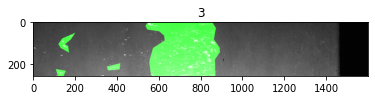

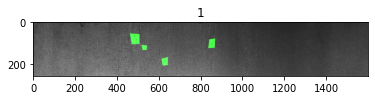

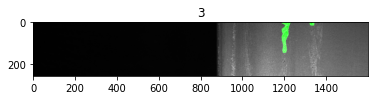

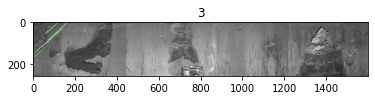

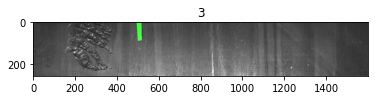

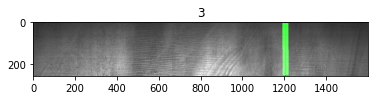

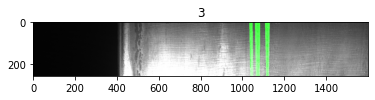

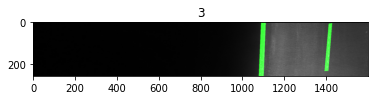

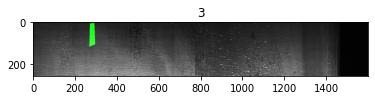

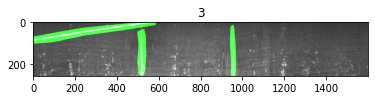

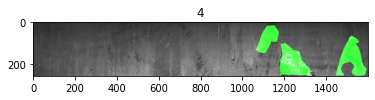

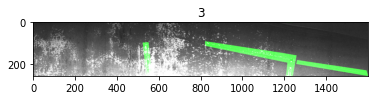

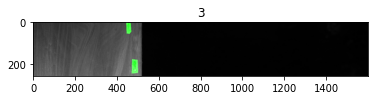

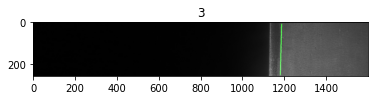

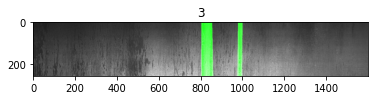

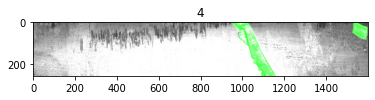

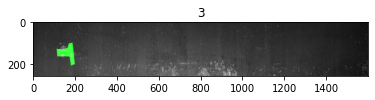

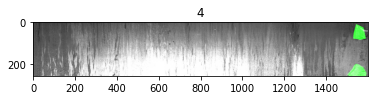

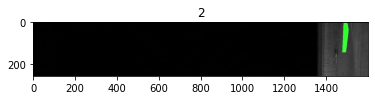

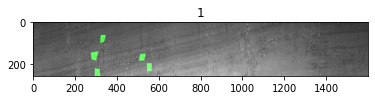

In [45]:
# Visualizando imagens
from utilities import rle2mask
for i in range(80, 100):
  img = io.imread(os.path.join(train_dir, test_df['ImageId'][i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  mask = rle2mask(test_df['EncodedPixels'][i], img.shape[0], img.shape[1])
  img[mask == 1,1] = 255
  plt.figure()
  plt.title(test_df['ClassId'][i])
  plt.imshow(img)

# Visualizando imagens das predições

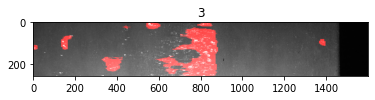

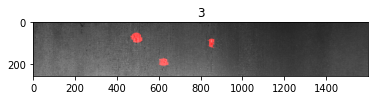

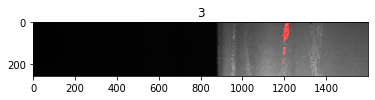

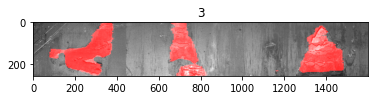

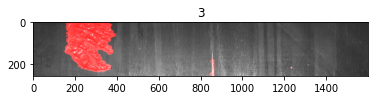

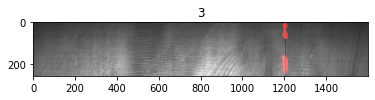

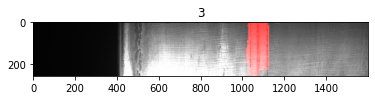

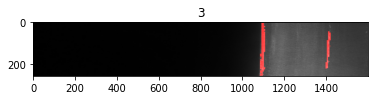

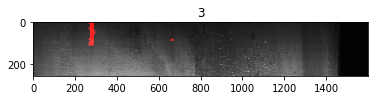

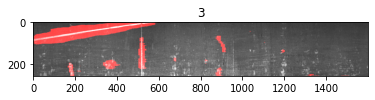

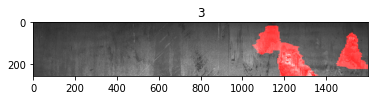

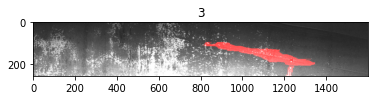

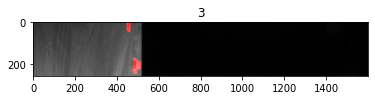

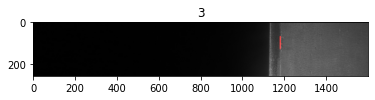

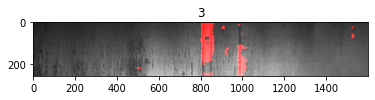

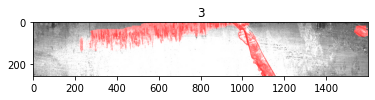

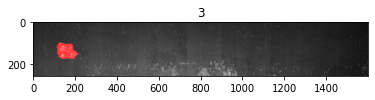

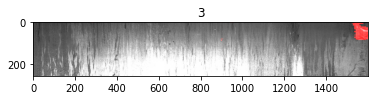

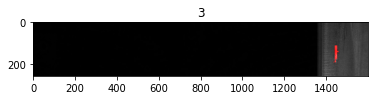

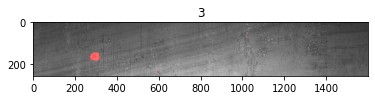

In [46]:
# Visualizando imagens
from utilities import rle2mask
for i in range(80, 100):
  img = io.imread(os.path.join(train_dir, df_pred['ImageId'][i]))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  mask = rle2mask(df_pred['EncodedPixels'][i], img.shape[0], img.shape[1])
  img[mask == 1,0] = 255
  plt.figure()
  plt.title(df_pred['ClassId'][i])
  plt.imshow(img)